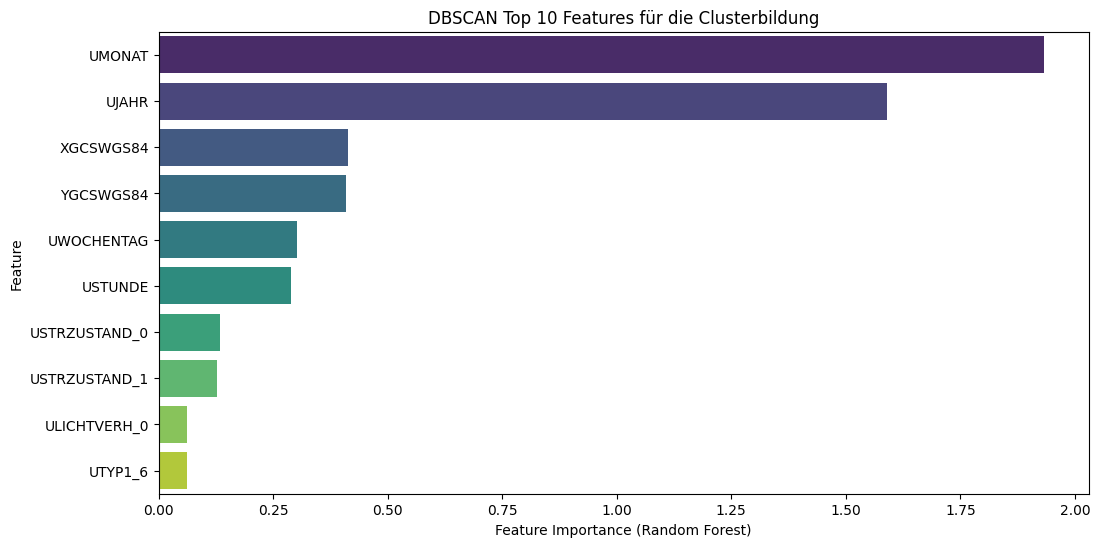

In [1]:
# Import der notwendigen Bibliotheken
import pandas as pd  # Für die Arbeit mit Datenframes (Datenverarbeitung)
from sklearn.ensemble import RandomForestClassifier  # Import des Random-Forest-Klassifikators für maschinelles Lernen
import seaborn as sns  # Für die Erstellung von ansprechenden Diagrammen
import matplotlib.pyplot as plt  # Zum Plotten von Diagrammen
import joblib  # Zum Speichern und Laden von trainierten Modellen
import numpy as np  # Für numerische Berechnungen und Arbeiten mit Arrays

# -----------------------------
# Lade Daten und DBSCAN-Labels
# -----------------------------
df_encoded = pd.read_csv("dbscan_encoded_data.csv")

# Lade das DBSCAN-Modell und die gespeicherten Cluster-Labels
dbscan = joblib.load('dbscan_model.pkl')
cluster_labels = np.load("dbscan_merged_clusters.npy")  # DBSCAN-Cluster-Labels

# Nur die ersten 45.000 Zeilen, die für das DBSCAN-Modell verwendet wurden
df_encoded_subset = df_encoded.head(45000).copy()

# Noise-Punkte (-1) entfernen, da sie keiner Cluster-Zugehörigkeit haben
df_encoded_subset = df_encoded_subset[cluster_labels[:45000] != -1]

# -----------------------------
# Training vom Random Forest Modell
# -----------------------------
chunk_size = 5000  # 5000 Zeilen pro Schritt verarbeiten
num_chunks = len(df_encoded_subset) // chunk_size + 1

# Liste für Feature-Importances
feature_importances_total = []

# Daten häppchenweise
for i in range(num_chunks):
    # Slice für den aktuellen Abschnitt
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(df_encoded_subset))
    
    # Kopie des DataFrames erstellen
    df_chunk = df_encoded_subset.iloc[start_idx:end_idx].copy()
    
    # Clusterzugehörigkeit für den aktuellen Abschnitt
    df_chunk.loc[:, 'Merged_Cluster'] = cluster_labels[start_idx:end_idx]

    # Cluster-Labels als Zielvariable
    y = df_chunk['Merged_Cluster']
    X = df_chunk.drop(columns=['Merged_Cluster'], errors='ignore')

    # Überprüfen, ob der DataFrame leer ist
    if len(X) == 0:
        continue  # Wenn leer, überspringen

    # Random Forest tarinieren
    rf = RandomForestClassifier(n_estimators=50, random_state=42)
    rf.fit(X, y)

    # Feature Importance berechnen
    feature_importances_chunk = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
    feature_importances_total.append(feature_importances_chunk)

# Alle Feature-Importances zusammenfassen
all_feature_importances = pd.concat(feature_importances_total, axis=0)

# Importances für jedes Feature summieren
feature_importances_aggregated = all_feature_importances.groupby('Feature')['Importance'].sum().reset_index()

# nach Wichtigkeit sortieren und Top 10
feature_importances_aggregated = feature_importances_aggregated.sort_values(by='Importance', ascending=False).head(10)

# -----------------------------
# Visualisierung
# -----------------------------
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances_aggregated['Importance'], 
            y=feature_importances_aggregated['Feature'], 
            palette='viridis', 
            hue=feature_importances_aggregated['Feature'], 
            legend=False)

plt.xlabel("Feature Importance (Random Forest)")
plt.ylabel("Feature")
plt.title("DBSCAN Top 10 Features für die Clusterbildung")
plt.savefig("output/plots/DBSCAN_Top10_Features.png", dpi=100, bbox_inches="tight")
plt.show()
